>The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

# Import the libraries needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Import the data

In [2]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# EDA

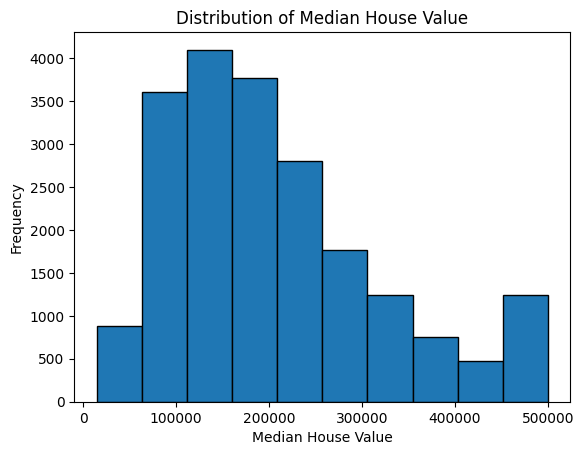

In [3]:
plt.hist(df['median_house_value'], bins=10, edgecolor='k')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.title('Distribution of Median House Value')
plt.show()

Based on the viz above, it looked that the `median_house_value` column has a long-tail distribution.

# Prepare the data

In [4]:
filtered_df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]

selected_columns = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

filtered_df = filtered_df[selected_columns].reset_index(drop=True)

# Checking missing values

In [5]:
filtered_df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

One feature that has missing values is `total_bedrooms`

# Checking the median

In [6]:
filtered_df['population'].median()

1195.0

The median of `population` column is 1195

# Split the data

In [7]:
# Shuffle the initial dataset
shuffled_data = filtered_df.sample(frac=1, random_state=42)

# Total size of 60%, 20%, and 20% of the dataset
total_samples = len(shuffled_data)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Split the dataset
df_train = shuffled_data[:train_size].copy()
df_val = shuffled_data[train_size:train_size + val_size].copy()
df_test = shuffled_data[train_size + val_size:].copy()

# Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Apply log transformation to 'median_house_value'
df_train['median_house_value'] = np.log1p(df_train['median_house_value'].values)
df_val['median_house_value'] = np.log1p(df_val['median_house_value'].values)
df_test['median_house_value'] = np.log1p(df_test['median_house_value'].values)

# Dealing with Missing Values

In [8]:
# Copy dataframe untuk menghindari modifikasi pada data asli
df_train_zero = df_train.copy()
df_val_zero = df_val.copy()
df_test_zero = df_test.copy()

# Isi missing values dengan 0
df_train_zero['total_bedrooms'].fillna(0, inplace=True)
df_val_zero['total_bedrooms'].fillna(0, inplace=True)
df_test_zero['total_bedrooms'].fillna(0, inplace=True)

# Hitung mean dari kolom total_bedrooms di df_train
mean_total_bedrooms = df_train['total_bedrooms'].mean()

# Copy dataframe untuk menghindari modifikasi pada data asli
df_train_mean = df_train.copy()
df_val_mean = df_val.copy()
df_test_mean = df_test.copy()

# Isi missing values dengan mean
df_train_mean['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)
df_val_mean['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)
df_test_mean['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)

# Split features and target in df zeros
X_train_zero = df_train_zero.drop(columns=['median_house_value']).values
X_val_zero = df_val_zero.drop(columns=['median_house_value']).values
X_test_zero = df_test_zero.drop(columns=['median_house_value']).values
y_train_zero = df_train_zero['median_house_value'].values
y_val_zero = df_val_zero['median_house_value'].values
y_test_zero = df_test_zero['median_house_value'].values

# Split features and target in df mean
X_train_mean = df_train_mean.drop(columns=['median_house_value']).values
X_val_mean = df_val_mean.drop(columns=['median_house_value']).values
X_test_mean = df_test_mean.drop(columns=['median_house_value']).values
y_train_mean = df_train_mean['median_house_value'].values
y_val_mean = df_val_mean['median_house_value'].values
y_test_mean = df_test_mean['median_house_value'].values

In [9]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [10]:
w_0, w = train_linear_regression(X_train_zero, y_train_zero)

y_pred_zero = w_0 + X_val_zero.dot(w)
print('validation for datasets filled with zero:', round(rmse(y_val_zero, y_pred_zero),2))

validation for datasets filled with zero: 0.34


In [11]:
w_0, w = train_linear_regression(X_train_mean, y_train_mean)

y_pred_mean = w_0 + X_val_mean.dot(w)
print('validation for datasets filled with mean:', round(rmse(y_val_mean, y_pred_mean),2))

validation for datasets filled with mean: 0.34


We can see from the results above that the RMSE from the zero-filled-dataset and mean-filled-dataset are the **same**. 

# Using Regularized Linear Regression

In [12]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [13]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train_zero, y_train_zero, r=r)
    print('r =', r, round(rmse(y_val_zero, w_0 + X_val_zero.dot(w)),2))

r = 0 0.34
r = 1e-06 0.34
r = 0.0001 0.34
r = 0.001 0.34
r = 0.01 0.34
r = 0.1 0.34
r = 1 0.34
r = 5 0.35
r = 10 0.35


Based on the results above, we can see the smallest `r` that give the best RMSE score is **0**.

# Value of STD

In [14]:
# Daftar seed yang akan diuji
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

# Loop melalui setiap seed
for seed in seed_values:
    # Set seed untuk pemisahan data
    shuffled_data = filtered_df.sample(frac=1, random_state=seed)
    
    # Total size of 60%, 20%, and 20% of the dataset
    total_samples = len(shuffled_data)
    train_size = int(0.6 * total_samples)
    val_size = int(0.2 * total_samples)
    test_size = total_samples - train_size - val_size

    # Split the dataset
    df_train = shuffled_data[:train_size].copy()
    df_val = shuffled_data[train_size:train_size + val_size].copy()
    df_test = shuffled_data[train_size + val_size:].copy()

    # Reset the index
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Apply log transformation to 'median_house_value'
    df_train['median_house_value'] = np.log1p(df_train['median_house_value'].values)
    df_val['median_house_value'] = np.log1p(df_val['median_house_value'].values)
    df_test['median_house_value'] = np.log1p(df_test['median_house_value'].values)
    
    # Isi missing values dengan 0
    df_train['total_bedrooms'].fillna(0, inplace=True)
    df_val['total_bedrooms'].fillna(0, inplace=True)
    df_test['total_bedrooms'].fillna(0, inplace=True)

    # Split features and target in df zeros
    X_train = df_train.drop(columns=['median_house_value']).values
    X_val = df_val.drop(columns=['median_house_value']).values
    y_train = df_train['median_house_value'].values
    y_val = df_val['median_house_value'].values

    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    rmse_scores.append(rmse(y_val, y_pred))

# Hitung standard deviation dari semua skor RMSE
std_deviation = np.std(rmse_scores)

# Round standard deviation ke 3 desimal
print(round(std_deviation, 3))

0.006


We can see that the std value is **0.005**

# RMSE with seed 9 and r 0.001

In [15]:
# Set seed untuk pemisahan data
shuffled_data = filtered_df.sample(frac=1, random_state=9)

# Total size of 60%, 20%, and 20% of the dataset
total_samples = len(shuffled_data)
train_size = int(0.6 * total_samples)
val_size = int(0.2 * total_samples)
test_size = total_samples - train_size - val_size

# Split the dataset
df_train = shuffled_data[:train_size].copy()
df_val = shuffled_data[train_size:train_size + val_size].copy()
df_test = shuffled_data[train_size + val_size:].copy()

# Reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Apply log transformation to 'median_house_value'
df_train['median_house_value'] = np.log1p(df_train['median_house_value'].values)
df_val['median_house_value'] = np.log1p(df_val['median_house_value'].values)
df_test['median_house_value'] = np.log1p(df_test['median_house_value'].values)

# Isi missing values dengan 0
df_train['total_bedrooms'].fillna(0, inplace=True)
df_val['total_bedrooms'].fillna(0, inplace=True)
df_test['total_bedrooms'].fillna(0, inplace=True)

# combine the dataset
df_combine = pd.concat([df_train, df_val])

# Split features and target in df combine
X_train = df_combine.drop(columns=['median_house_value']).values
X_val = df_test.drop(columns=['median_house_value']).values
y_train = df_combine['median_house_value'].values
y_val = df_test['median_house_value'].values

# train the model
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_val.dot(w)
print(rmse(y_val, y_pred))

0.3349544624953353


We can see from result above that the value of RMSE is **0.33**